<a href="https://colab.research.google.com/github/shatabdabasu/waste_logistics_simulation/blob/main/waste_logistics_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

7. Multimodal Foundation Models for Waste Co-Processing Forecasting and Carbon-Aware Logistics in Cement Supply Chains

# Problem Statement :
Given a fixed daily waste collection target for a cement plant and a set of waste suppliers at varying distances, the objective is to determine daily supplier selection strategies that meet the target while minimizing transport-related carbon emissions. Two approaches are evaluated: a baseline distance-based heuristic and a forecast-aware decision strategy. Performance is assessed through single-day validation and month-long simulation based on cumulative transport emissions.

# Model Parameters & Constraints



Capacity per trip:
C = 20 tons

Trips per truck per day:
Unlimited

Minimum daily waste target:
Wₘᵢₙ = 60 tons

Daily collection rule:
Collect until W ≥ 60, then stop

Suppliers:
S = {S₁, S₂, …, S₁₂}

Waste available at supplier i on day d:
wᵢ(d)

Waste constraint:
wᵢ(d) decreases after collection

Routing:
Plant → Sᵢ → Plant (hub-and-spoke)

Distance to supplier i:
dᵢ ∈ [12, 80] km

Distance counted per trip:
Δ = dᵢ

CO₂ emission factor:
e = 0.9 kg/km

Carbon per trip:
CO₂ = e × dᵢ

Objective

Daily constraint:
W(d) ≥ 60

Optimization goal (30 days):
min Σ CO₂

Decision Rules

Baseline:

select Sᵢ in increasing dᵢ


Proposed:

select Sᵢ in decreasing (wᵢ / dᵢ)

Fairness Condition

Same T, C, Wₘᵢₙ, dᵢ, e, wᵢ(d) for both models

Only supplier order differs

One-line math summary

Given Wₘᵢₙ = 60, minimize Σ(e × dᵢ) by optimal supplier ordering.

#  Dataset Generation

## 1. waste supplies dataset

In [3]:
from google.colab import files
uploaded = files.upload()

Saving waste_30days.csv to waste_30days.csv


In [4]:
# verify
import os

os.listdir()


['.config', 'waste_30days.csv', 'sample_data']

In [5]:
import pandas as pd

waste_df = pd.read_csv("waste_30days.csv")
waste_df.head()


,Day,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12
0,1,18,15,14,12,11,10,9,8,10,7,8,6
1,2,19,15,14,12,11,10,9,8,10,7,8,6
2,3,18,16,14,13,11,10,9,8,10,7,8,6
3,4,19,16,15,13,12,10,9,8,11,7,8,6
4,5,20,16,15,13,12,11,9,8,11,7,8,6


## 2. Distance data set

The route structure is HUB-AND-SPOKE.
The cement plant is the center (hub).
Each supplier is a spoke.
Plant → Supplier → Plant
Each trip is:

one supplier per trip

direct

round-trip

A hub-and-spoke logistics structure is assumed, with the cement plant acting as a central hub and waste suppliers as spokes. Each transport operation involves a direct round-trip between the plant and a single supplier, consistent with typical waste and alternative fuel logistics practices.

In [6]:


# Distance data (km)
distance_data = {
    "S1": 12,
    "S2": 18,
    "S3": 22,
    "S4": 28,
    "S5": 35,
    "S6": 40,
    "S7": 45,
    "S8": 50,
    "S9": 55,
    "S10": 60,
    "S11": 65,
    "S12": 80
}


# 2. Baseline Method

What happens if the plant uses NO intelligence?

Use 30 days

Baseline: sortest distances


“The baseline policy visits suppliers with closest distance and collects the actual available waste revealed upon arrival, stopping when the daily target is reached. No forecasting or historical information is used.”

In [7]:
# -----------------------------
# PARAMETERS
# -----------------------------

DAILY_TARGET = 60              # minimum waste (tons) to collect per day
EMISSION_FACTOR = 0.9          # kg of CO2 emitted per km travelled

# -----------------------------
# BASELINE: DISTANCE-FIRST POLICY
# -----------------------------

total_CO2 = 0                  # total CO2 emitted over all days

# Sort suppliers once based on distance (nearest supplier first)
supplier_order = sorted(distance_data.keys(), key=lambda s: distance_data[s])
baseline_daily_CO2 = []   #

# Loop over each day in the dataset
for day in range(len(waste_df)):

    collected = 0              # total waste collected on the current day
    daily_CO2 = 0              # CO2 emitted on the current day

    # Visit suppliers in increasing order of distance
    for supplier in supplier_order:

        # Stop visiting suppliers once daily target is reached
        if collected >= DAILY_TARGET:
            break

        # Collect actual waste available at this supplier on this day
        collected += waste_df.loc[day, supplier]

        # Add CO2 emitted for travelling to this supplier
        daily_CO2 += distance_data[supplier] * EMISSION_FACTOR

    # Add today's CO2 emissions to cumulative total
    total_CO2 += daily_CO2
    baseline_daily_CO2.append(total_CO2)   #

    # Print daily results
    print(
        f"Day {day + 1}: "
        f"Waste = {collected} tons, "
        f"CO2 = {daily_CO2:.2f} kg"
    )

# Print total CO2 emissions over the full 30-day period
print("\nTOTAL CO2 over 30 days:", round(total_CO2, 2), "kg")
baseline_CO2 = total_CO2   # store baseline result


Day 1: Waste = 70 tons, CO2 = 103.50 kg
Day 2: Waste = 60 tons, CO2 = 72.00 kg
Day 3: Waste = 61 tons, CO2 = 72.00 kg
Day 4: Waste = 63 tons, CO2 = 72.00 kg
Day 5: Waste = 64 tons, CO2 = 72.00 kg
Day 6: Waste = 65 tons, CO2 = 72.00 kg
Day 7: Waste = 67 tons, CO2 = 72.00 kg
Day 8: Waste = 68 tons, CO2 = 72.00 kg
Day 9: Waste = 70 tons, CO2 = 72.00 kg
Day 10: Waste = 70 tons, CO2 = 72.00 kg
Day 11: Waste = 69 tons, CO2 = 72.00 kg
Day 12: Waste = 72 tons, CO2 = 72.00 kg
Day 13: Waste = 73 tons, CO2 = 72.00 kg
Day 14: Waste = 74 tons, CO2 = 72.00 kg
Day 15: Waste = 60 tons, CO2 = 46.80 kg
Day 16: Waste = 74 tons, CO2 = 72.00 kg
Day 17: Waste = 61 tons, CO2 = 46.80 kg
Day 18: Waste = 62 tons, CO2 = 46.80 kg
Day 19: Waste = 63 tons, CO2 = 46.80 kg
Day 20: Waste = 63 tons, CO2 = 46.80 kg
Day 21: Waste = 62 tons, CO2 = 46.80 kg
Day 22: Waste = 65 tons, CO2 = 46.80 kg
Day 23: Waste = 65 tons, CO2 = 46.80 kg
Day 24: Waste = 66 tons, CO2 = 46.80 kg
Day 25: Waste = 67 tons, CO2 = 46.80 kg
Day 26: 

# Proposed Method

Past data

   ↓

ML model (forecast waste)

   ↓

Decision rule (waste / distance)

   ↓

Supplier order

   ↓
   
Collect → Stop at 60 → CO₂


Forcasting model

The system uses a rolling, supplier-wise lag-based forecasting approach to estimate short-term waste generation. For each supplier and for each day in the simulation, historical waste data up to the previous day is used to train a baseline linear regression model. The model is formulated using a lag-1 structure, where the waste generated on the previous day serves as the input feature and the waste generated on the current day is treated as the target variable.

Training samples are constructed from consecutive day pairs (yesterday → today), allowing the model to learn short-term dependency patterns in waste generation. The trained model is then used to predict the expected waste for the current day based on the most recent observed value. This process is repeated in a rolling manner for each supplier and each day, ensuring that only past information is used for forecasting.

The predicted waste values are not used directly for emissions calculation but instead serve as a decision-support signal to prioritize suppliers during daily collection, optimizing route selection while respecting operational constraints.

In [8]:
import numpy as np
from sklearn.linear_model import LinearRegression

# -----------------------------
# PARAMETERS
# -----------------------------
DAILY_TARGET = 60
EMISSION_FACTOR = 0.9

total_CO2 = 0

suppliers = list(distance_data.keys())

proposed_daily_CO2 = []

# Loop day by day (rolling simulation)
for day in range(1, len(waste_df)):

    predicted_waste = {}

    # -------- ML FORECAST STEP --------
    for supplier in suppliers:

        # past waste values
        y = waste_df.loc[:day-1, supplier].values

        # need at least 2 points for lag model
        if len(y) < 2:
            predicted_waste[supplier] = y[-1]   # fallback
        else:
            X = y[:-1].reshape(-1, 1)    # yesterday's waste
            y_target = y[1:]             # today's waste

            model = LinearRegression()
            model.fit(X, y_target)

            predicted_waste[supplier] = model.predict([[y[-1]]])[0]

    # -------- DECISION STEP --------
    scores = {
        s: predicted_waste[s] / distance_data[s]
        for s in suppliers
    }

    supplier_order = sorted(scores.keys(), key=lambda s: scores[s], reverse=True)

    collected = 0
    daily_CO2 = 0

    # -------- EXECUTION STEP --------
    for supplier in supplier_order:
        if collected >= DAILY_TARGET:
            break

        collected += waste_df.loc[day, supplier]
        daily_CO2 += distance_data[supplier] * EMISSION_FACTOR

    total_CO2 += daily_CO2
    proposed_daily_CO2.append(total_CO2)

    print(
        f"Day {day + 1}: "
        f"Waste = {collected} tons, "
        f"CO2 = {daily_CO2:.2f} kg"
    )

print("\nTOTAL CO2 over 30 days (Proposed Model):", round(total_CO2, 2), "kg")
proposed_CO2 = total_CO2


Day 2: Waste = 60 tons, CO2 = 72.00 kg
Day 3: Waste = 61 tons, CO2 = 72.00 kg
Day 4: Waste = 63 tons, CO2 = 72.00 kg
Day 5: Waste = 64 tons, CO2 = 72.00 kg
Day 6: Waste = 65 tons, CO2 = 72.00 kg
Day 7: Waste = 67 tons, CO2 = 72.00 kg
Day 8: Waste = 68 tons, CO2 = 72.00 kg
Day 9: Waste = 70 tons, CO2 = 72.00 kg
Day 10: Waste = 70 tons, CO2 = 72.00 kg
Day 11: Waste = 69 tons, CO2 = 72.00 kg
Day 12: Waste = 72 tons, CO2 = 72.00 kg
Day 13: Waste = 73 tons, CO2 = 72.00 kg
Day 14: Waste = 74 tons, CO2 = 72.00 kg
Day 15: Waste = 60 tons, CO2 = 46.80 kg
Day 16: Waste = 74 tons, CO2 = 72.00 kg
Day 17: Waste = 61 tons, CO2 = 46.80 kg
Day 18: Waste = 62 tons, CO2 = 46.80 kg
Day 19: Waste = 63 tons, CO2 = 46.80 kg
Day 20: Waste = 63 tons, CO2 = 46.80 kg
Day 21: Waste = 62 tons, CO2 = 46.80 kg
Day 22: Waste = 65 tons, CO2 = 46.80 kg
Day 23: Waste = 65 tons, CO2 = 46.80 kg
Day 24: Waste = 66 tons, CO2 = 46.80 kg
Day 25: Waste = 67 tons, CO2 = 46.80 kg
Day 26: Waste = 69 tons, CO2 = 46.80 kg
Day 27: 

# 5. Results Comparison

In [13]:
# -----------------------------
# COMPARISON OF RESULTS
# -----------------------------

# Absolute CO2 reduction
co2_saved = baseline_CO2 - proposed_CO2

# Percentage CO2 reduction
co2_reduction_percent = (co2_saved / baseline_CO2) * 100

# Print comparison summary
print("Baseline Total CO2 (kg):", round(baseline_CO2, 2))
print("Proposed Total CO2 (kg):", round(proposed_CO2, 2))
print("CO2 Saved (kg):", round(co2_saved, 2))
print("CO2 Reduction (%):", round(co2_reduction_percent, 2))


Baseline Total CO2 (kg): 1813.5
Proposed Total CO2 (kg): 1710.0
CO2 Saved (kg): 103.5
CO2 Reduction (%): 5.71


Annual CO₂ Reduction (Test Notes)

Baseline (30 days): 1813.5 kg CO₂
Proposed (30 days): 1710.0 kg CO₂

Baseline (annual):
1813.5 × 12 = 21,762 kg ≈ 21.76 tons

Proposed (annual):
1710.0 × 12 = 20,520 kg ≈ 20.52 tons

Annual CO₂ reduction:
21,762 − 20,520 = 1,242 kg ≈ 1.24 tons

Annual percentage reduction:
(1,242 / 21,762) × 100 ≈ 5.71%

Result:
The proposed ML-based strategy achieves an estimated ~5.7% annual reduction in transport-related CO₂ emissions (~1.24 tons per plant) under similar operating conditions

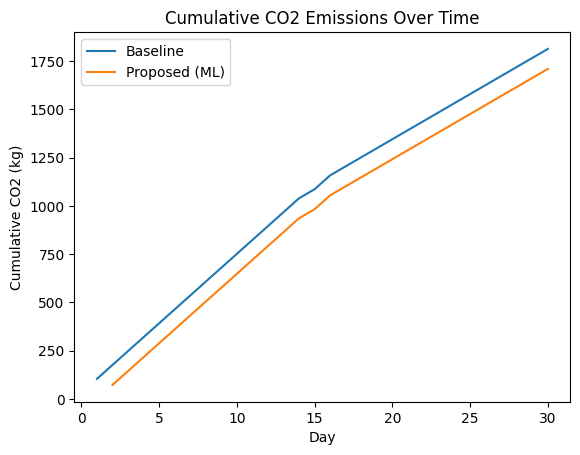

In [10]:
import matplotlib.pyplot as plt

days_baseline = range(1, len(baseline_daily_CO2) + 1)
days_proposed = range(2, len(proposed_daily_CO2) + 2)

plt.figure()
plt.plot(days_baseline, baseline_daily_CO2, label="Baseline")
plt.plot(days_proposed, proposed_daily_CO2, label="Proposed (ML)")

plt.xlabel("Day")
plt.ylabel("Cumulative CO2 (kg)")
plt.title("Cumulative CO2 Emissions Over Time")
plt.legend()
plt.show()
